## GANs

Neste exercício aprenderemos a desenvolver uma GAN simples utilizando o framework [TF-GAN](https://github.com/tensorflow/gan).

Para isto, utilizaremos o dataset [MNIST](http://yann.lecun.com/exdb/mnist/) para que nossa rede seja capaz de gerar dígitos escritos artificiais.

O Primeiro passo é visualizar como nossa base de treinamento se parece.

Inicie rodando ```pip install tensorflow_gan``` no seu ambiente conda.

In [1]:
import tensorflow as tf
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
#Fazer Gan na mao

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt


image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
))
print(type(label),label)
print(type(image), image.shape)
plt.imshow(image[0,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[1,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[2,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[3,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[4,:,:,0],cmap="gray")
plt.figure()
train_image = image
train_labels = label

In [ ]:
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test', 
    batch_size=-1, 
    as_supervised=True,
))

print(type(image), image.shape)
plt.imshow(image[0,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[1,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[2,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[3,:,:,0],cmap="gray")
plt.figure()
plt.imshow(image[4,:,:,0],cmap="gray")
plt.figure()
test_image = image

In [ ]:
train_dataset = (train_image.reshape((len(train_image),28,28))) / 255.
test_dataset = (test_image.reshape((len(test_image),28,28))) / 255.



In [ ]:
plt.imshow(train_dataset[0,:,:],cmap="gray")
plt.figure()
plt.imshow(test_dataset[1,:,:],cmap="gray")
plt.figure()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization,Reshape, Activation, Dense, Flatten, MaxPooling2D

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten

embedding_dim = 16
def _batch_norm(inputs, is_training):
  return tf.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

#Generator
def unconditional_generator(noise,  weight_decay=2.5e-5):
    """Generator to produce unconditional MNIST images."""
    model = Sequential()
    model.add(Dense(input_dim=64, units=512))
    model.add(Activation('relu'))
    
    model.add(Dense(64*7*7))
    model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 64), input_shape=(64*7*7,))) # 7x7 image
    
    model.add(UpSampling2D(size=(2, 2))) # 14x14 image
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D(size=(2, 2))) # 28x28 image
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('relu'))
    
    
    return model

def unconditional_discriminator(img, unused_conditioning, weight_decay=2.5e-5):
    model = Sequential()
    
    model.add(Conv2D(32,(5, 5),padding='same',input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    
    model.add(Dense(512))
    
    model.add(Activation('relu'))
    
    model.add(Dense(1))
 
    return model

#Discriminator

In [ ]:
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.keras.optimizers.Adam(lr)

In [ ]:
import tensorflow_gan as tfgan
import tensorflow as tf
gan_estimator = tfgan.estimator.GANEstimator(     
        generator_fn=unconditional_generator,
        discriminator_fn=unconditional_discriminator,        
        generator_loss_fn=tfgan.losses.modified_generator_loss,
        discriminator_loss_fn=tfgan.losses.modified_discriminator_loss,        
        generator_optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
        discriminator_optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
        add_summaries=tfgan.estimator.SummaryType.IMAGES)

In [ ]:
train_dataset.shape

In [ ]:
def input_fn():
    return train_dataset
gan_estimator.train(input_fn, max_steps=next_step)

In [ ]:
#Here
def input_fn():
    return tf.convert_to_tensor(train_dataset)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

def generator_cost_function(y_actual, y_predicted):
        n_examples = y_actual.shape[0]
        #batch = tf.convert_to_tensor(np.zeros((n_examples*2, 28, 28, 1)), dtype=tf.float32)
        batch = tf.concat([y_actual, y_predicted], axis=0)
        #batch[n_examples:, :, :, 0] = y_predicted
        #Designa labels inversas para calcular a loss(o gerador tenta fazer o discriminador errar)
        labels = np.zeros(batch.shape[0])
        labels[n_examples:] = 1. #1 é a label dos exemplos reais para o discriminador e para os falsos no gerador
        prediction = gan_discriminator.predict(batch)
        bce = tf.keras.losses.BinaryCrossentropy(tf.convert_to_tensor(labels),prediction)
        return bce
    
    

dim_random_vector = 64
gan_generator = gan_generator_model(dim_random_vector)
gan_generator.compile(optimizer=Adam(0.0002), loss=generator_cost_function, metrics=['accuracy'])
gan_generator.summary()

gan_discriminator = gan_discriminator_model()
gan_discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
gan_discriminator.summary()

In [ ]:
batch_size = 64
repet = 1000
epochs = 100


for i in range(repet):
       
    
    gan_generator.fit(np.random.rand(len(train_dataset),dim_random_vector),train_dataset, epochs = epochs,  verbose=2)
    
    batch = np.zeros((len(train_dataset)*2,28,28,1))
    batch[:len(train_dataset), :, :, :] =train_dataset
    batch[len(train_dataset):, :, :, :] = gan_generator.predict(np.random.rand(len(train_dataset),dim_random_vector))
    labels = np.zeros(len(train_dataset)*2)
    labels[:len(train_dataset)] = 1.
    gan_discriminator.fit(batch, labels, epochs= epochs, verbose=2)



In [ ]:
def gan_generator_model(dim_random):
    model = Sequential()
    model.add(Dense(units=512, input_dim=dim_random, activation='relu'))
    model.add(Activation('relu'))
    
    model.add(Dense(64*7*7))
    model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 64), input_shape=(64*7*7,))) # 7x7 image
    
    model.add(UpSampling2D(size=(2, 2))) # 14x14 image
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D(size=(2, 2))) # 28x28 image
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    #model.add(Dense(28*28))
    #model.add(Reshape((28, 28, 1)))
    #model.add(Activation('relu'))
    return model

def gan_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32,(5, 5),padding='same',input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    #model.add(Activation('relu'))
    
    model.add(Dense(1, activation='sigmoid'))
 
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


generator = gan_generator_model(dim_random_vector)
generator.summary()
discriminator = gan_discriminator_model()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()

In [ ]:
train_dataset = train_dataset.reshape((len(train_dataset),28,28,1))
batch_size = 512
half_batch = int(batch_size/2)
epochs = 10000

errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))

plt.ion()
# manually enumerate epochs
for i in range(epochs):
    batch = np.zeros((batch_size, 28, 28, 1))
    batch_y = np.zeros(batch_size)
    # prepare real samples
    random_indices = np.random.choice(len(train_dataset), size=half_batch, replace=False)
    batch[:half_batch, :, :, :] = train_dataset[random_indices, :, :,:]
    #Label for the real samples is 0, so no need to change batch_y

    batch[half_batch:, :, :] = generator.predict(np.random.rand(half_batch, dim_random_vector))
    batch_y[half_batch:] += 1.
    
    if i%1000 == 0:
        print_images(batch[-25:])
        
   
        
    
   
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    # create inverted labels for the fake samples
    x_gan = np.random.rand(batch_size, dim_random_vector)
    y_gan = np.zeros((batch_size)) + 1.
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)


In [ ]:
plt.scatter(range(len(errors_discrim)),errors_discrim)
plt.scatter(range(len(errors_generator)),errors_generator)
plt.figure()

generated = generator.predict(np.random.rand(50, dim_random_vector))
plt.imshow(generated[0,:,:].reshape(28,28),cmap="gray")
plt.figure()
plt.imshow(generated[1,:,:].reshape(28,28),cmap="gray")
plt.figure()

print(sum(discriminator.predict(generated)))
print(sum(discriminator.predict(train_dataset[:50, :, :, :])))


In [ ]:
def print_images(samples):
    plt.close()
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(samples[i].reshape((28,28)), cmap='gray_r')
    plt.show()
    
print_images(batch)
generated = generator.predict(np.random.rand(50, dim_random_vector))
print(batch[0])

In [3]:
#Aqui
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dropout, Input
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization,Reshape, Activation, Dense, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras import initializers

import numpy as np

In [ ]:



image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
))
train_image = image
train_labels = label
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test', 
    batch_size=-1, 
    as_supervised=True,
))

test_image = image
test_labels = label

train_dataset = (train_image.reshape((len(train_image),28,28))-127.5)/127.5
test_dataset = (test_image.reshape((len(test_image),28,28))-127.5)/127.5
train_dataset = train_dataset.reshape((len(train_dataset),28,28,1))
test_dataset = test_dataset.reshape((len(test_dataset),28,28,1))

dim_random_vector = 100

In [22]:
def print_images(samples):
    plt.close()
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(samples[i].reshape((28,28)), cmap='gray_r')
    plt.show()
    

def gan_generator_model(dim_random):
    model = Sequential()
    if True:
        model.add(Dense(256, input_dim=dim_random, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        model.add(LeakyReLU(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1024))
        model.add(LeakyReLU(0.2))
        model.add(Dense(28*28, activation='tanh'))
        model.add(Reshape((28,28,1)))
    else:
        model.add(Dense(128*7*7, input_dim=dim_random, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        model.add(LeakyReLU(0.2))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
        model.add(LeakyReLU(0.2))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

    return model


def gan_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28,28,1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
 
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    discriminator.trainable = False
    ganInput = Input(shape=(dim_random_vector,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan


generator = gan_generator_model(dim_random_vector)
generator.summary()
discriminator = gan_discriminator_model()
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 1024)             

epoch: 0


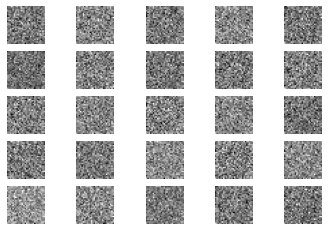

Errors Discrimin: 0.6944396495819092
Errors Generator:0.6969716548919678
Perc Discrim:0.5
epoch: 100


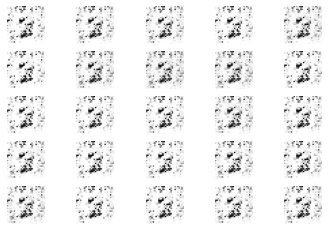

Errors Discrimin: 0.7283022403717041
Errors Generator:0.7732019424438477
Perc Discrim:0.3
epoch: 200


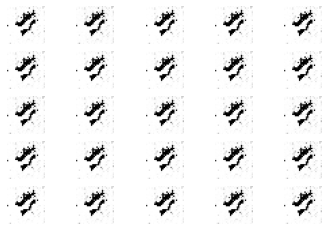

Errors Discrimin: 1.671056866645813
Errors Generator:0.48175573348999023
Perc Discrim:0.855
epoch: 300


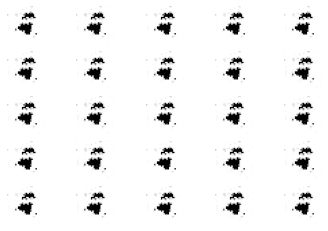

Errors Discrimin: 1.1722660064697266
Errors Generator:0.5083352327346802
Perc Discrim:0.915
epoch: 400


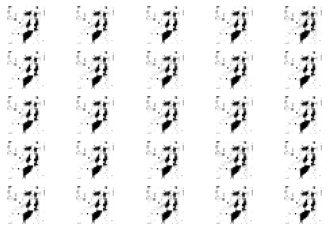

Errors Discrimin: 1.3233695030212402
Errors Generator:0.5284285545349121
Perc Discrim:0.89
epoch: 500


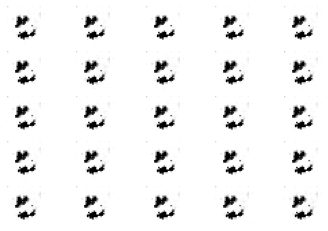

Errors Discrimin: 1.788947582244873
Errors Generator:0.30591490864753723
Perc Discrim:0.975
epoch: 600


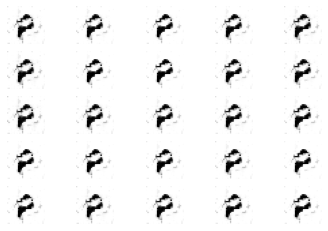

Errors Discrimin: 1.6424522399902344
Errors Generator:0.4105951488018036
Perc Discrim:0.935
epoch: 700


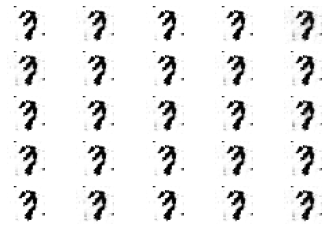

Errors Discrimin: 1.5567079782485962
Errors Generator:0.4025792181491852
Perc Discrim:0.94
epoch: 800


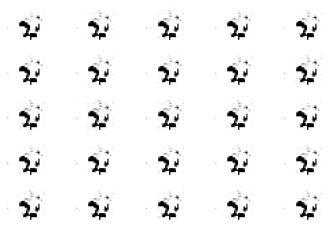

Errors Discrimin: 1.9394060373306274
Errors Generator:0.2902008295059204
Perc Discrim:0.97
epoch: 900


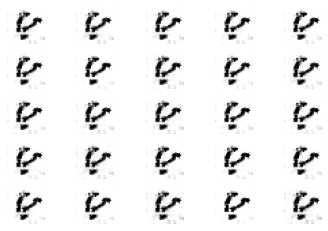

Errors Discrimin: 1.4637141227722168
Errors Generator:0.44901758432388306
Perc Discrim:0.95
epoch: 1000


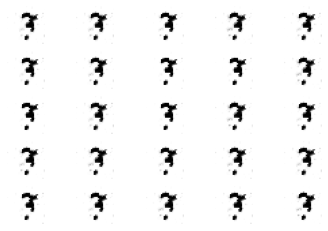

Errors Discrimin: 1.2758724689483643
Errors Generator:0.4471853971481323
Perc Discrim:0.92
epoch: 1100


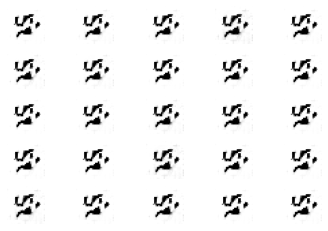

Errors Discrimin: 1.4922713041305542
Errors Generator:0.40350568294525146
Perc Discrim:0.985
epoch: 1200


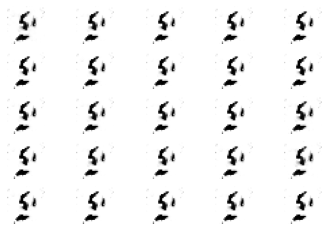

Errors Discrimin: 1.7013487815856934
Errors Generator:0.29024145007133484
Perc Discrim:0.97
epoch: 1300


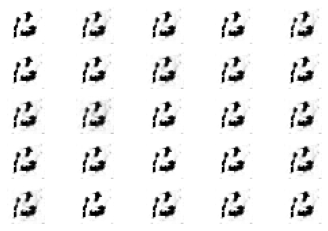

Errors Discrimin: 2.078446865081787
Errors Generator:0.24763981997966766
Perc Discrim:0.97
epoch: 1400


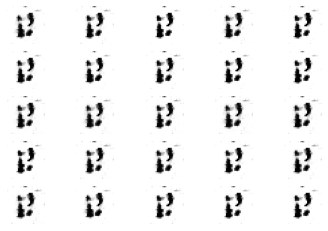

Errors Discrimin: 1.9125754833221436
Errors Generator:0.3299267292022705
Perc Discrim:0.96
epoch: 1500


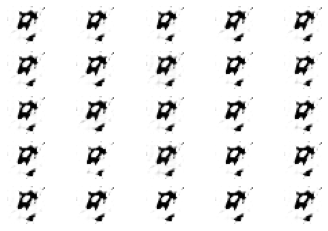

Errors Discrimin: 2.333960771560669
Errors Generator:0.36478114128112793
Perc Discrim:0.955
epoch: 1600


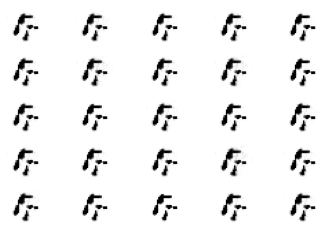

Errors Discrimin: 2.089787721633911
Errors Generator:0.2777784764766693
Perc Discrim:0.97
epoch: 1700


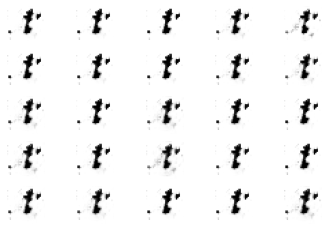

Errors Discrimin: 1.6192487478256226
Errors Generator:0.6261622905731201
Perc Discrim:0.89
epoch: 1800


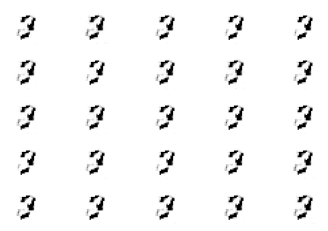

Errors Discrimin: 0.9680854678153992
Errors Generator:0.4090383052825928
Perc Discrim:0.9
epoch: 1900


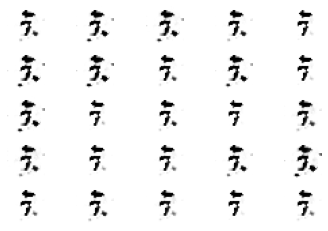

Errors Discrimin: 1.6893911361694336
Errors Generator:0.3530973196029663
Perc Discrim:0.915
epoch: 2000


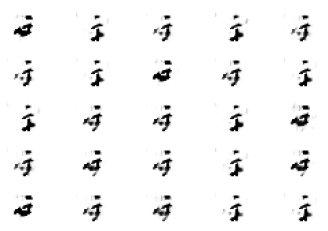

Errors Discrimin: 1.8116798400878906
Errors Generator:0.3607572615146637
Perc Discrim:0.94
epoch: 2100


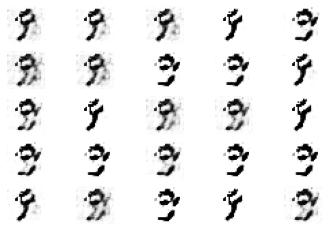

Errors Discrimin: 1.9654955863952637
Errors Generator:0.41909095644950867
Perc Discrim:0.91
epoch: 2200


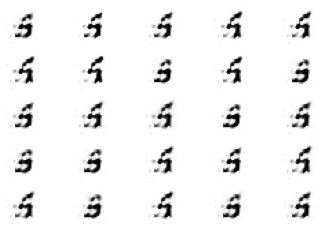

Errors Discrimin: 1.6670126914978027
Errors Generator:0.49318379163742065
Perc Discrim:0.92
epoch: 2300


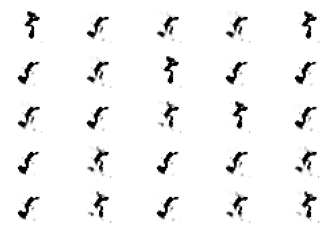

Errors Discrimin: 1.8989720344543457
Errors Generator:0.28023433685302734
Perc Discrim:0.96
epoch: 2400


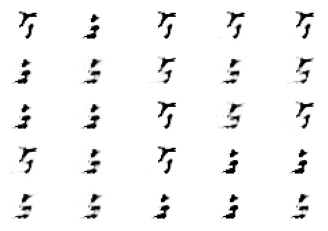

Errors Discrimin: 1.3371176719665527
Errors Generator:0.426619291305542
Perc Discrim:0.885
epoch: 2500


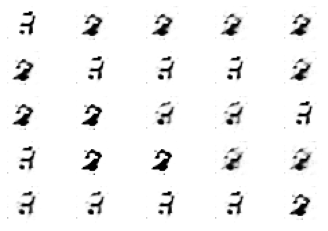

Errors Discrimin: 1.3134628534317017
Errors Generator:0.36167895793914795
Perc Discrim:0.98
epoch: 2600


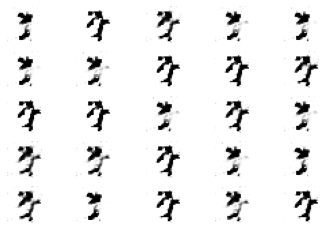

Errors Discrimin: 1.4300800561904907
Errors Generator:0.4571048319339752
Perc Discrim:0.81
epoch: 2700


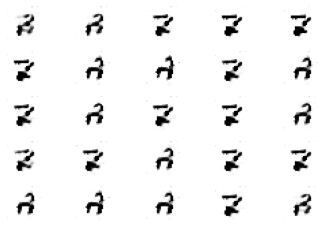

Errors Discrimin: 1.7704172134399414
Errors Generator:0.2954666018486023
Perc Discrim:0.99
epoch: 2800


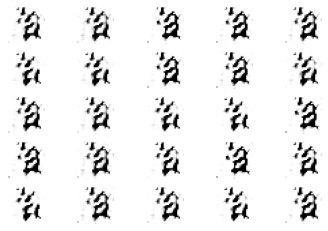

Errors Discrimin: 2.1848056316375732
Errors Generator:0.2760079801082611
Perc Discrim:0.99
epoch: 2900


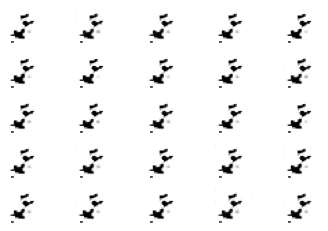

Errors Discrimin: 3.0995097160339355
Errors Generator:0.26151764392852783
Perc Discrim:0.955
epoch: 3000


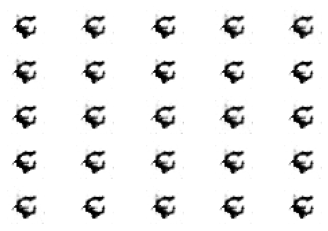

Errors Discrimin: 0.7176834940910339
Errors Generator:0.6991103887557983
Perc Discrim:0.49
epoch: 3100


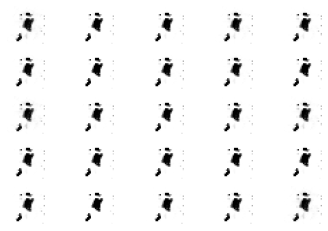

Errors Discrimin: 2.090040922164917
Errors Generator:0.37054896354675293
Perc Discrim:0.96
epoch: 3200


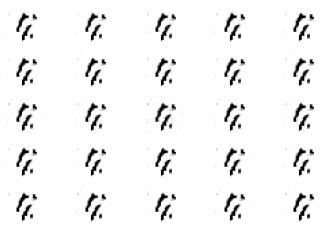

Errors Discrimin: 2.7457401752471924
Errors Generator:0.2727642059326172
Perc Discrim:0.96
epoch: 3300


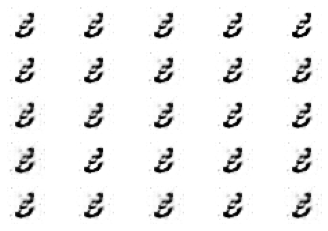

Errors Discrimin: 2.177666664123535
Errors Generator:0.36438021063804626
Perc Discrim:0.875
epoch: 3400


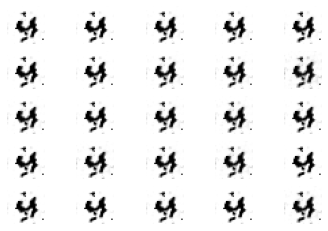

Errors Discrimin: 2.5334553718566895
Errors Generator:0.24623960256576538
Perc Discrim:0.98
epoch: 3500


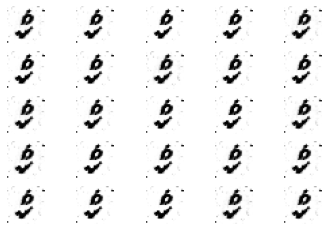

Errors Discrimin: 2.0582573413848877
Errors Generator:0.2529364824295044
Perc Discrim:0.99
epoch: 3600


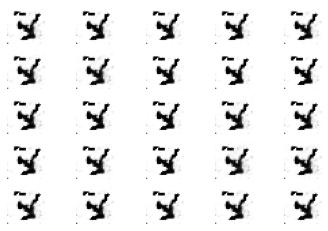

Errors Discrimin: 2.2794265747070312
Errors Generator:0.25502121448516846
Perc Discrim:0.985
epoch: 3700


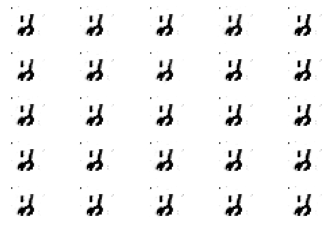

Errors Discrimin: 2.14455509185791
Errors Generator:0.27248066663742065
Perc Discrim:0.985
epoch: 3800


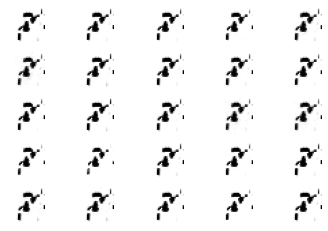

Errors Discrimin: 1.998936653137207
Errors Generator:0.3163207769393921
Perc Discrim:0.99
epoch: 3900


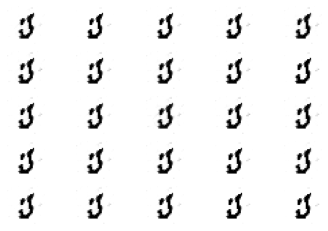

Errors Discrimin: 2.9758920669555664
Errors Generator:0.2868688106536865
Perc Discrim:0.965
epoch: 4000


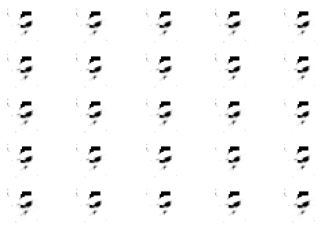

Errors Discrimin: 1.947974443435669
Errors Generator:0.2865680456161499
Perc Discrim:0.985
epoch: 4100


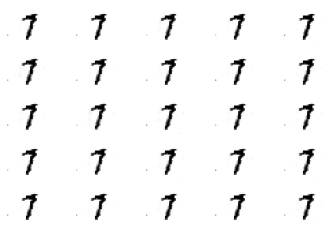

Errors Discrimin: 2.284992218017578
Errors Generator:0.2503213882446289
Perc Discrim:0.985
epoch: 4200


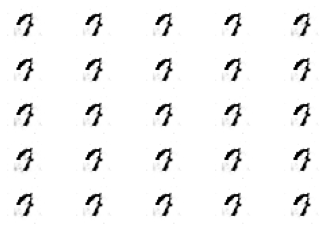

Errors Discrimin: 2.3195810317993164
Errors Generator:0.2779690623283386
Perc Discrim:0.97
epoch: 4300


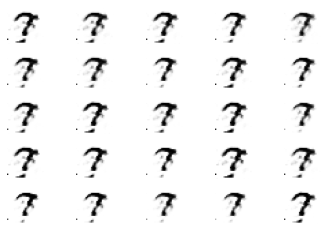

Errors Discrimin: 2.3134353160858154
Errors Generator:0.48251184821128845
Perc Discrim:0.93
epoch: 4400


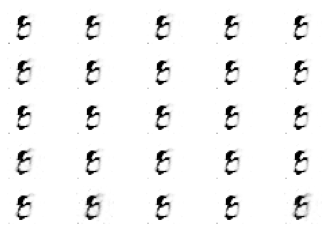

Errors Discrimin: 2.3769357204437256
Errors Generator:0.2773139178752899
Perc Discrim:0.955
epoch: 4500


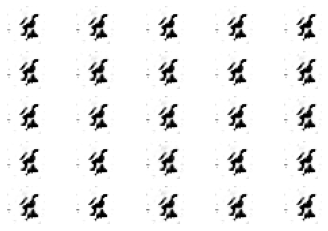

Errors Discrimin: 2.4846444129943848
Errors Generator:0.24204802513122559
Perc Discrim:0.985
epoch: 4600


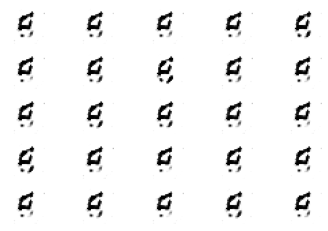

Errors Discrimin: 2.0499422550201416
Errors Generator:0.32315242290496826
Perc Discrim:0.96
epoch: 4700


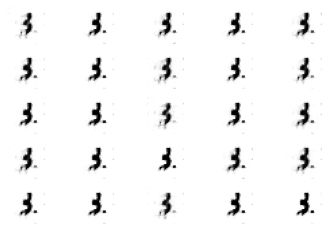

Errors Discrimin: 1.8402116298675537
Errors Generator:0.383700430393219
Perc Discrim:0.955
epoch: 4800


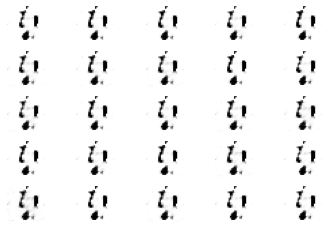

Errors Discrimin: 2.0145316123962402
Errors Generator:0.23999865353107452
Perc Discrim:0.975
epoch: 4900


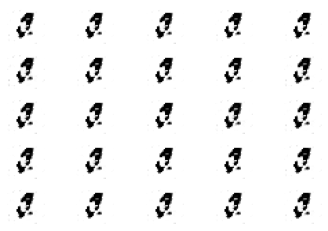

Errors Discrimin: 2.3302559852600098
Errors Generator:0.28716257214546204
Perc Discrim:0.955


In [23]:

batch_size = 128
half_batch = int(batch_size/2)
epochs = 5000

test_size = 200
half_test = int(test_size /2)

errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))
perc_discrim = np.zeros((epochs))

plt.ion()
# manually enumerate epochs
for i in range(epochs):
    batch = np.zeros((batch_size, 28, 28, 1))
    batch_y = np.zeros(batch_size)
    # prepare real samples
    random_indices = np.random.choice(len(train_dataset), size=half_batch, replace=False)
    batch[:half_batch, :, :, :] = train_dataset[random_indices, :, :,:]
    #Label for the real samples is 0, so no need to change batch_y

    batch[half_batch:, :, :] = generator.predict(np.random.normal(0, 1, size=[half_batch, dim_random_vector]))
    batch_y[half_batch:] += 0.9 
   
        
    
    discriminator.trainable = True
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    # create inverted labels for the fake samples
    x_gan = np.random.normal(0, 1, size=[batch_size, dim_random_vector])
    y_gan = np.zeros((batch_size)) 
    discriminator.trainable = False
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)
    
    test_batch = np.zeros((test_size, 28, 28, 1))
    test_y     = np.zeros(test_size)
    test_y[half_test:] += 1.
    random_indices = np.random.choice(len(test_dataset), size=half_test, replace=False)

    test_batch[:half_test, :, :, :] = test_dataset[random_indices, :, :]
    test_batch[half_test:, :, :] = generator.predict(np.random.normal(0, 1, size=[half_test, dim_random_vector]))
    predictions =  (discriminator.predict(test_batch).ravel() > 0.5) * 1.
    
    perc_discrim[i] = sum(predictions == test_y)/test_size
    
    if i%100 == 0:
        print("epoch: "+str(i))
        print_images(generator.predict(np.random.normal(0, 1, size=[25, dim_random_vector])))
        print("Errors Discrimin: " + str(errors_generator[i]))
        print("Errors Generator:" + str(errors_discrim[i]))
        print("Perc Discrim:" + str(perc_discrim[i]))

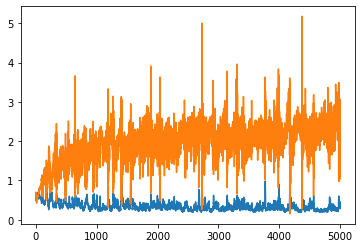

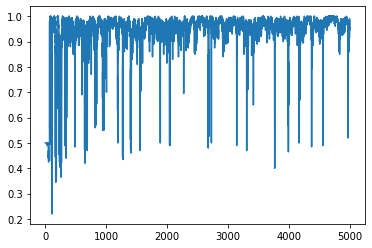

In [8]:
plt.plot(errors_discrim)

plt.plot(errors_generator)

plt.figure()
plt.plot(perc_discrim)

In [ ]:
errors_discrim, errors_generator

[[-0.96596815  0.61684816  1.23007032 -1.18216267  0.66885633 -3.1647617
  -0.21807202  1.46511533  0.55723573  0.25096105 -0.47091294  1.11172727
  -0.99381721 -0.77733354 -0.29489303  2.15192871  0.72221548  0.23809747
  -0.59846079  1.14708849  0.3380731   0.02678694  1.28036837  1.22742076
   0.59670594 -1.90042579 -1.41888207 -0.30688839 -1.59811792 -1.66304055
  -0.63565439  0.23153718  0.12395676 -0.35887479 -0.14647979  0.82439234
   0.69186682 -0.393529   -1.05826075  0.71270552 -0.42961318  0.46971466
   1.00048588  0.89524873 -0.54067031 -0.93613027  0.10153881  0.17703766
  -0.26274037  0.56376811  0.73226526  1.61609335  2.14967026 -0.70092402
  -0.90207594  0.99944285  0.51485733 -1.34403751 -1.01263163  0.79495742
   0.96742021 -0.81960868  0.87212288  2.74978832 -0.01757147 -0.14874589
   0.53032224  0.38000992  0.13436991  0.84937944 -1.15548314  1.05690451
  -0.76419705 -0.2220064   0.3599909   0.87877222  0.14724305 -0.13346914
   0.59678485  0.67494461 -0.58305234 -

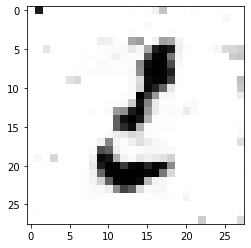

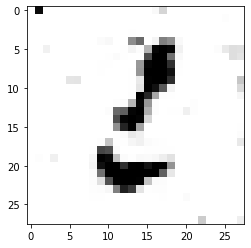

In [16]:
rnd = np.random.normal(0,1, size=[2, dim_random_vector])
samples = generator.predict(rnd)
plt.imshow(samples[0].reshape((28,28)), cmap='gray_r')
plt.figure()
plt.imshow(samples[1].reshape((28,28)), cmap='gray_r')
print(rnd)


In [12]:
input_dim= 5
def real_function(x):
    return np.multiply(x,x)

def generate_samples(n_samples):
    result = np.zeros((n_samples,2))
    max_x,min_x = -1,+1
    x = (np.random.rand(n_samples)*(max_x-min_x)) + min_x
    result[:,0] = x
    result[:,1] = real_function(x)
    return result
def generator_predict(n_samples, input_dim, generator):
    rnd = np.random.normal(0, 1, size=[n_samples, input_dim])
    return generator.predict(rnd)

train_dataset = generate_samples(10000)
test_dataset = generate_samples(10000)



In [22]:
def print_images(input_v):
    plt.close()
    x = input_v[:,0]
    y = input_v[:,1]
    plt.scatter(x,y)
    plt.show()
def gan_generator_model(input_dim):
    model = Sequential()
    model.add(Dense(50, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Dense(32))
    model.add(LeakyReLU(0.2))
    model.add(Dense(2, activation='tanh'))
    return model


def gan_discriminator_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
 
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    discriminator.trainable = False
    ganInput = Input(shape=(input_dim,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan


generator = gan_generator_model(input_dim)
generator.summary()
discriminator = gan_discriminator_model()
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 50)                300       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1632      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 66        
Total params: 1,998
Trainable params: 1,998
Non-trainable params: 0
____________________________________________________

epoch: 0


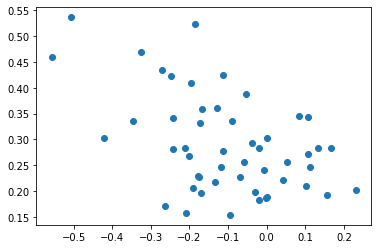

Errors Discrimin: 0.6831497550010681
Errors Generator:0.673898458480835
Perc Discrim:0.484375
epoch: 1000


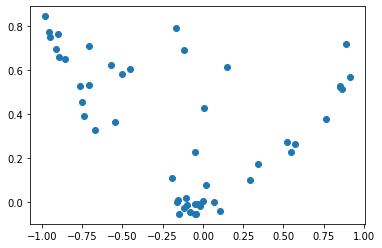

Errors Discrimin: 0.5967814922332764
Errors Generator:0.6855413913726807
Perc Discrim:0.5
epoch: 2000


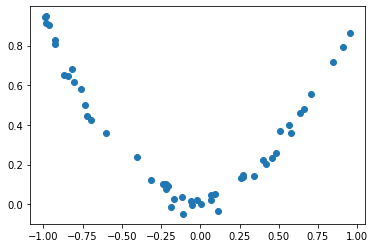

Errors Discrimin: 0.6030850410461426
Errors Generator:0.6902155876159668
Perc Discrim:0.5
epoch: 3000


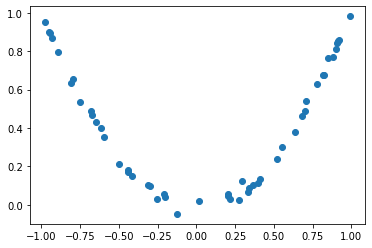

Errors Discrimin: 0.604013979434967
Errors Generator:0.6923797130584717
Perc Discrim:0.5
epoch: 4000


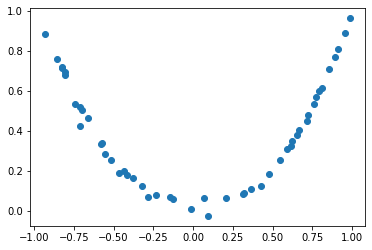

Errors Discrimin: 0.5980165004730225
Errors Generator:0.6857362985610962
Perc Discrim:0.5
epoch: 5000


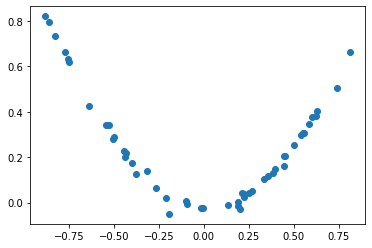

Errors Discrimin: 0.6023804545402527
Errors Generator:0.6863069534301758
Perc Discrim:0.5
epoch: 6000


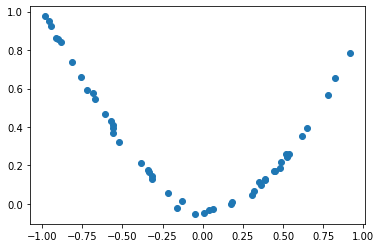

Errors Discrimin: 0.5982239842414856
Errors Generator:0.6863627433776855
Perc Discrim:0.5
epoch: 7000


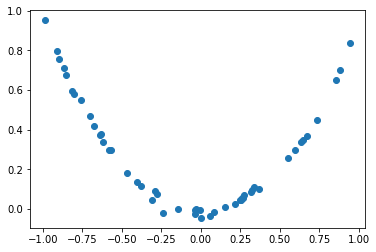

Errors Discrimin: 0.6024322509765625
Errors Generator:0.6886812448501587
Perc Discrim:0.5
epoch: 8000


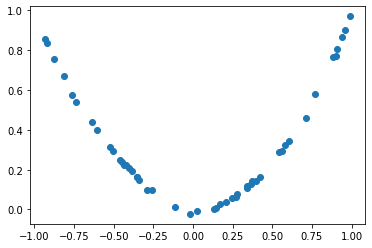

Errors Discrimin: 0.6012322306632996
Errors Generator:0.6896382570266724
Perc Discrim:0.5
epoch: 9000


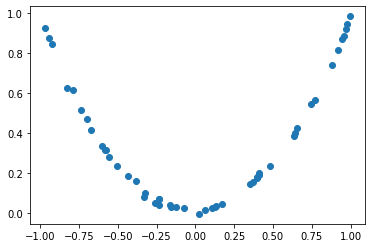

Errors Discrimin: 0.5965662002563477
Errors Generator:0.6869363188743591
Perc Discrim:0.5


In [24]:
batch_size = 32
half_batch = int(batch_size/2)
epochs = 10000

test_size = 64
half_test = int(test_size /2)

errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))
perc_discrim = np.zeros((epochs))

plt.ion()
# manually enumerate epochs
for i in range(epochs):
    batch = np.zeros((batch_size, 2))
    batch_y = np.zeros(batch_size)
   
    # prepare real samples
    random_indices = np.random.choice(len(train_dataset), size=half_batch, replace=False)
    batch[:half_batch, :] = train_dataset[random_indices, :]
    #Label for the real samples is 0, so no need to change batch_y

    batch[half_batch:, :] = generator.predict(np.random.normal(0, 1, size=[half_batch, input_dim]))
    batch_y[half_batch:] += 0.9 
   
        
    
    discriminator.trainable = True
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    # create inverted labels for the fake samples
    x_gan = np.random.normal(0, 1, size=[batch_size, input_dim])
    y_gan = np.zeros((batch_size)) 
    discriminator.trainable = False
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)
    
    test_batch = np.zeros((test_size, 2))
    test_y     = np.zeros(test_size)
    test_y[half_test:] += 1.
    
    random_indices = np.random.choice(len(test_dataset), size=half_test, replace=False)

    test_batch[:half_test, :] = test_dataset[random_indices, :]
    test_batch[half_test:, :] = generator.predict(np.random.normal(0, 1, size=[half_test, input_dim]))
    predictions =  (discriminator.predict(test_batch).ravel() > 0.5) * 1.
    
    perc_discrim[i] = sum(predictions == test_y)/test_size
    
    if i%1000 == 0:
        print("epoch: "+str(i))
        print_images(generator.predict(np.random.normal(0, 1, size=[50, input_dim])))
        print("Errors Discrimin: " + str(errors_generator[i]))
        print("Errors Generator:" + str(errors_discrim[i]))
        print("Perc Discrim:" + str(perc_discrim[i]))

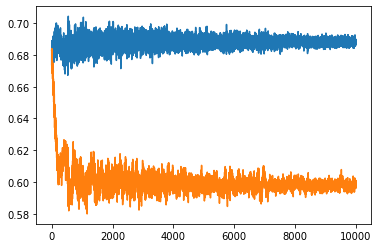

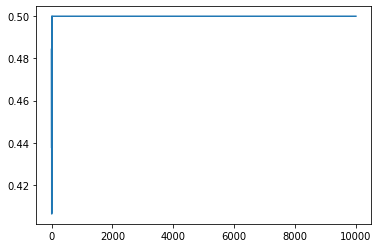

In [25]:
plt.plot(errors_discrim)

plt.plot(errors_generator)

plt.figure()
plt.plot(perc_discrim)

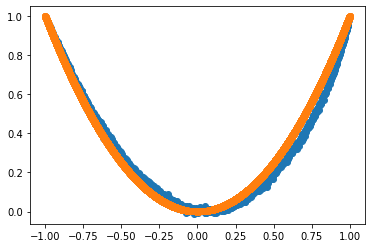

In [27]:
gen = generator.predict(np.random.normal(0, 1, size=[1000, input_dim]))
real = generate_samples(10000)

plt.scatter(gen[:,0],gen[:,1])
plt.scatter(real[:,0], real[:,1])